### Import

In [1]:
%load_ext autoreload
%autoreload 2
import world_cup_helpers

import pandas as pd
from keras.models import load_model

Using TensorFlow backend.


# PREPROCESSING

### Read data

In [2]:
results = pd.read_csv('results.csv')

### Create master dataframe

In [3]:
master_df = world_cup_helpers.create_master_df(results)

### Add team experience data

In [4]:
master_df['experience'] = master_df.apply(world_cup_helpers.get_experience, axis=1)

### Add mean age

In [5]:
master_df['age'] = master_df.apply(world_cup_helpers.get_age, axis=1)

### Add host team dummy

In [6]:
master_df['host_team'] = master_df.apply(world_cup_helpers.get_host_team, axis=1)

### Form matrices

In [7]:
x_res_train, x_meta_train, y_train = world_cup_helpers.form_matrices(master_df[master_df.year <= 2014])  # <= because we train on all data the last time
x_res_test, x_meta_test, y_test = world_cup_helpers.form_matrices(master_df[master_df.year == 2014])

# MODEL

### Define predictive model

In [8]:
# model = world_cup_helpers.build_world_cup_predictor(x_res_train.shape, x_meta_train.shape)

### Train and save model

In [9]:
# model, timestamp = world_cup_helpers.train_world_cup_predictor(model, x_res_train, x_meta_train, y_train)
# model.save('./models/{}/model.h5'.format(timestamp))

### Load model

In [10]:
timestamp = '20180614-104252'
model = load_model('./models/{}/model.h5'.format(timestamp))

# PREDICT TOURNAMENT

### Create dataframe

In [11]:
year = 2018

if year == 2018:
    import world_cup_2018_info as world_cup_schedule
    
    world_cup_pred = pd.read_pickle('world_cup_2018_group_stage.pkl')
    
else:
    import world_cup_2014_info as world_cup_schedule
    
    world_cup_pred = master_df[master_df.year == year][:16*3]
    
    # Add game day column
    world_cup_pred['game_day'] = world_cup_helpers.calculate_round(world_cup_pred) + 1
    
    # Add group columns
    world_cup_pred['group'] = world_cup_pred.apply(lambda row: world_cup_schedule.groups[row.home_team] if row.game_day <= 3 else None, axis=1)

### Add results manually

In [12]:
def add_result(home_team, away_team, home_score, away_score):
    world_cup_pred.loc[
        (world_cup_pred.home_team == home_team) & (world_cup_pred.away_team == away_team), 
        ['home_score', 'away_score']
    ] = home_score, away_score

# add_result('Russia', 'Saudi Arabia', 2, 0)
# add_result('Egypt', 'Uruguay', 1, 3)
# add_result('Morocco', 'Iran', 4, 0)
# add_result('Portugal', 'Spain', 0, 1)

### Predict group stage

In [13]:
world_cup_pred = world_cup_helpers.simulate_group_stage(world_cup_pred, model)

### Sum up groups

In [14]:
group_tables = world_cup_helpers.sum_up_groups(world_cup_pred, pred_scores='unplayed_only')
group_tables

{'A':               scored  conceded  diff  points
 Uruguay         4.27      2.35  1.92     7.0
 Russia          3.43      3.14  0.29     4.0
 Egypt           2.85      3.74 -0.89     2.0
 Saudi Arabia    2.63      3.95 -1.32     2.0,
 'B':           scored  conceded  diff  points
 Spain       4.32      2.32  2.00     5.0
 Portugal    3.45      3.16  0.29     5.0
 Iran        3.18      3.53 -0.35     3.0
 Morocco     2.39      4.33 -1.94     1.0,
 'C':            scored  conceded  diff  points
 France       4.59      2.07  2.52     7.0
 Denmark      3.19      3.41 -0.22     3.0
 Peru         3.12      3.68 -0.56     2.0
 Australia    2.53      4.27 -1.74     2.0,
 'D':            scored  conceded  diff  points
 Argentina    4.62      2.23  2.39     7.0
 Nigeria      3.01      3.70 -0.69     3.0
 Croatia      3.11      3.59 -0.48     2.0
 Iceland      2.75      3.97 -1.22     2.0,
 'E':              scored  conceded  diff  points
 Brazil         4.46      2.13  2.33     7.0
 Switzerlan

### Round of 16

In [15]:
world_cup_pred = world_cup_helpers.simulate_round_of_16(world_cup_pred, model, group_tables, world_cup_schedule.round_of_16, world_cup_schedule.round_of_16_dates)
world_cup_pred[world_cup_pred.group.apply(lambda x: x.startswith('1/8'))][['home_team', 'pred_home_score', 'pred_away_score', 'away_team']]

1,home_team,pred_home_score,pred_away_score,away_team
48,France,1.75,0.54,Nigeria
49,Uruguay,1.06,1.19,Portugal
50,Spain,1.58,0.65,Russia
51,Argentina,1.58,0.7,Denmark
52,Brazil,1.54,0.65,Sweden
53,Belgium,1.54,0.67,Japan
54,Germany,1.35,0.78,Switzerland
55,Poland,0.82,1.28,England


#### Add results manually

In [16]:
# add_result('Spain', 'Russia', 2, 1)

### Quarter-finals

In [17]:
world_cup_pred = world_cup_helpers.simulate_quarter_finals(world_cup_pred, model, world_cup_schedule.quarter_finals, world_cup_schedule.quarter_final_dates)
world_cup_pred[world_cup_pred.group.apply(lambda x: x.startswith('1/4'))][['home_team', 'pred_home_score', 'pred_away_score', 'away_team']]

1,home_team,pred_home_score,pred_away_score,away_team
56,France,1.11,1.08,Portugal
57,Brazil,1.29,0.84,Belgium
58,Germany,1.27,0.83,England
59,Spain,0.77,1.32,Argentina


#### Add results manually

In [18]:
# add_result('Spain', 'Argentina', 1, 2)

### Semi-finals

In [19]:
world_cup_pred = world_cup_helpers.simulate_semi_finals(world_cup_pred, model, world_cup_schedule.semi_finals, world_cup_schedule.semi_final_dates)
world_cup_pred[world_cup_pred.group.apply(lambda x: x.startswith('1/2'))][['home_team', 'pred_home_score', 'pred_away_score', 'away_team']]

1,home_team,pred_home_score,pred_away_score,away_team
60,France,0.76,1.32,Brazil
61,Germany,1.02,1.11,Argentina


#### Add results manually

In [20]:
# add_result('France', 'Brazil', 1, 3)

### Final and play-off for third place

In [21]:
world_cup_pred = world_cup_helpers.simulate_finals(world_cup_pred, model, world_cup_schedule.finals, world_cup_schedule.final_dates)
world_cup_pred[-2:][['home_team', 'pred_home_score', 'pred_away_score', 'away_team']]

1,home_team,pred_home_score,pred_away_score,away_team
62,France,0.76,1.32,Germany
63,Brazil,1.02,1.11,Argentina


#### Add results manually

In [22]:
# add_result('France', 'Germany', 0, 2)

### All results

In [23]:
world_cup_pred[['home_team', 'pred_home_score', 'home_score', 'away_score', 'pred_away_score', 'away_team']]

1,home_team,pred_home_score,home_score,away_score,pred_away_score,away_team
0,Russia,1.27,None,None,0.9,Saudi Arabia
1,Egypt,0.85,None,None,1.35,Uruguay
2,Morocco,1.04,None,None,1.15,Iran
3,Portugal,0.81,None,None,1.29,Spain
4,France,1.76,None,None,0.54,Australia
5,Argentina,1.72,None,None,0.58,Iceland
6,Peru,1.17,None,None,1.1,Denmark
7,Croatia,1.23,None,None,0.99,Nigeria
8,Costa Rica,1.02,None,None,1.18,Serbia
9,Germany,1.38,None,None,0.72,Mexico


### Distribution of goals per game

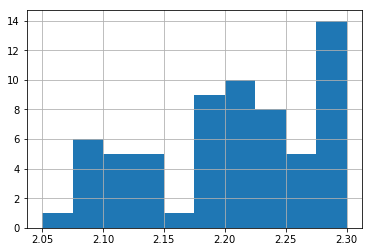

In [24]:
%matplotlib inline
world_cup_pred.loc[:, ['pred_home_score', 'pred_away_score']].sum(axis=1).hist();